# Early Classification Model
- https://link.springer.com/article/10.1007/s10618-020-00690-z
- train model for each time stamp
- train single class SVM to determine if prediction is good enough

In [152]:
import os
import numpy as np
import pandas as pd
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM
import torch
import torch.nn as nn
from pyts.transformation import WEASEL
from pyts.multivariate.classification import MultivariateClassifier
from pyts.classification import KNeighborsClassifier, TimeSeriesForest, BOSSVS
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.base import clone

import LSTM_Training

## Data loading and formatting

In [5]:
X_path = 'data_training/X.npy'
Y_path = 'data_training/Y.npy'
X_flat_path = 'data_training/X_flat.npy'
Y_flat_path = 'data_training/Y_flat.npy'

In [6]:
X = np.load(X_path)
Y = np.load(Y_path)
X_flat = np.load(X_flat_path)
Y_flat = np.load(Y_flat_path)
print(X.shape)
print(Y.shape)
print(X_flat.shape)
print(Y_flat.shape)

(9022, 21, 32)
(9022,)
(189462, 34)
(189462,)


In [8]:
X_train_dict = {}
Y_train_dict = {}
X_flat_train_dict = {}
Y_flat_train_dict = {}

X_test_dict = {}
Y_test_dict = {}
X_flat_test_dict = {}
Y_flat_test_dict = {}


for i, timestamp in enumerate(np.arange(60000, 1260000, 60000)):
    X_tmp = X[:,:i+2,:]
    Y_tmp = Y
    X_tmp_flat = X_flat[X_flat[:,0] <= timestamp,:]
    Y_tmp_flat = Y_flat[X_flat[:,0] <= timestamp]
    X_train_dict[timestamp], X_test_dict[timestamp], Y_train_dict[timestamp], Y_test_dict[timestamp] = train_test_split(X_tmp, Y_tmp, test_size=0.2, random_state=42)
    X_flat_train_dict[timestamp], X_flat_test_dict[timestamp], Y_flat_train_dict[timestamp], Y_flat_test_dict[timestamp] = train_test_split(X_tmp_flat, Y_tmp_flat, test_size=0.2, random_state=42)
    print(f'timestamp: {timestamp}, X shape: {X_train_dict[timestamp].shape}, X_flat shape: {X_flat_train_dict[timestamp].shape}')


timestamp: 60000, X shape: (7217, 2, 32), X_flat shape: (14435, 34)
timestamp: 120000, X shape: (7217, 3, 32), X_flat shape: (21652, 34)
timestamp: 180000, X shape: (7217, 4, 32), X_flat shape: (28870, 34)
timestamp: 240000, X shape: (7217, 5, 32), X_flat shape: (36088, 34)
timestamp: 300000, X shape: (7217, 6, 32), X_flat shape: (43305, 34)
timestamp: 360000, X shape: (7217, 7, 32), X_flat shape: (50523, 34)
timestamp: 420000, X shape: (7217, 8, 32), X_flat shape: (57740, 34)
timestamp: 480000, X shape: (7217, 9, 32), X_flat shape: (64958, 34)
timestamp: 540000, X shape: (7217, 10, 32), X_flat shape: (72176, 34)
timestamp: 600000, X shape: (7217, 11, 32), X_flat shape: (79393, 34)
timestamp: 660000, X shape: (7217, 12, 32), X_flat shape: (86611, 34)
timestamp: 720000, X shape: (7217, 13, 32), X_flat shape: (93828, 34)
timestamp: 780000, X shape: (7217, 14, 32), X_flat shape: (101046, 34)
timestamp: 840000, X shape: (7217, 15, 32), X_flat shape: (108264, 34)
timestamp: 900000, X shape:

In [93]:
# for LSTM
X_dict = {}
Y_dict = {}

for i, timestamp in enumerate(np.arange(60000, 1260000, 60000)):
    X_dict[timestamp] = X[:,:i+2,:]
    Y_dict[timestamp] = Y
    print(f'timestamp: {timestamp}, X shape: {X_dict[timestamp].shape}')


timestamp: 60000, X shape: (9022, 2, 32)
timestamp: 120000, X shape: (9022, 3, 32)
timestamp: 180000, X shape: (9022, 4, 32)
timestamp: 240000, X shape: (9022, 5, 32)
timestamp: 300000, X shape: (9022, 6, 32)
timestamp: 360000, X shape: (9022, 7, 32)
timestamp: 420000, X shape: (9022, 8, 32)
timestamp: 480000, X shape: (9022, 9, 32)
timestamp: 540000, X shape: (9022, 10, 32)
timestamp: 600000, X shape: (9022, 11, 32)
timestamp: 660000, X shape: (9022, 12, 32)
timestamp: 720000, X shape: (9022, 13, 32)
timestamp: 780000, X shape: (9022, 14, 32)
timestamp: 840000, X shape: (9022, 15, 32)
timestamp: 900000, X shape: (9022, 16, 32)
timestamp: 960000, X shape: (9022, 17, 32)
timestamp: 1020000, X shape: (9022, 18, 32)
timestamp: 1080000, X shape: (9022, 19, 32)
timestamp: 1140000, X shape: (9022, 20, 32)
timestamp: 1200000, X shape: (9022, 21, 32)


## Pipeline Definition
- parameter is class for each individual timestamp model
    - need to use multivariate time series classification model
- for now, only use one class SVM (ocSVM) for quality assurance (parent) classifier

### Basic ML pipeline

In [100]:
# Early classifier for basic ML classification models
# For classic ML, need flat along time axis
class EarlyClassifier():
    def __init__(self, sub_model):
        self.sub_model = sub_model
        self.qa_model = OneClassSVM(kernel='rbf')
        self.timestamp_models = {}
        self.qa_models = {}
        self.scores = {}

    '''
    params:
        - X_dict: keys are timestamps, values are training data for timestamp
        - Y_dict: keys are timestamps, values are training labels for timestamp
    '''
    def fit(self, X_dict, Y_dict):
        for timestamp in X_dict.keys():
            print(f'Training model at timestamp {timestamp}...')
            self.timestamp_models[timestamp] = clone(self.sub_model)
            self.timestamp_models[timestamp].fit(X_dict[timestamp], Y_dict[timestamp])
            c = self.timestamp_models[timestamp].predict(X_dict[timestamp])
            # filter for only correct predictions
            correct_pred = np.equal(c,Y_dict[timestamp])
            c = c[correct_pred]
            P = self.timestamp_models[timestamp].predict_proba(X_dict[timestamp])[correct_pred]
            # P = list(zip(P[:,0],P[:,1]))
            d = np.subtract(np.sort(P, axis=1)[:,0],np.sort(P, axis=1)[:,1])
            X_qa = np.array(list(zip(c, P[:,0], P[:,1], d)))
            self.qa_models[timestamp] = clone(self.qa_model)
            self.qa_models[timestamp].fit(X_qa)
        print('model training complete')

    '''
    params:
        - X_dict: keys are timestamps, values are prediction data for timestamp
    return:
        - predictions: dict with keys as timestamps, values as list of tuples of predicted class and QA class value
    '''
    def predict(self, X_dict):
        predictions = {}
        for timestamp, X in X_dict.items():
            pred = self.timestamp_models[timestamp].predict(X)
            qa_pred = self.qa_models[timestamp].predict(X)
            predictions[timestamp] = list(zip(pred, qa_pred))
        return predictions
    
    def score(self, X_test_dict, Y_test_dict):
        for timestamp in X_test_dict.keys():
            score = self.timestamp_models[timestamp].score(X_test_dict[timestamp],Y_test_dict[timestamp])
            print(f'model score at timestamp {timestamp}: {score}')
            self.scores[timestamp] = score * 100

    def save_models(self, dir):
        for timestamp in self.timestamp_models.keys():
            print(f'writing models for timestamp {timestamp}...')
            timestamp_filename = f'{dir}/timestamp_model_{str(timestamp)}.joblib'
            qa_filename = f'{dir}/qa_model_{str(timestamp)}.joblib'
            joblib.dump(self.timestamp_models[timestamp], timestamp_filename)
            joblib.dump(self.qa_models[timestamp], qa_filename)
        print('model writing complete')

### LSTM

In [115]:
# Early classifier for LSTM
# Use LSTM_Training.py and 3d dataset
class LSTMEarlyClassifier():
    def __init__(self, model_parameters):
        self.model_parameters = model_parameters
        self.qa_model = OneClassSVM(kernel='rbf')
        self.timestamp_models = {}
        self.qa_models = {}
        self.scores = {}
        self.train_losses = {}
        self.test_losses = {}

    '''
    params:
        - X_dict: keys are timestamps, values are training data for timestamp
        - Y_dict: keys are timestamps, values are training labels for timestamp
    '''
    def fit(self, X_dict, Y_dict):
        for timestamp in X_dict.keys():
            print(f'Training model at timestamp {timestamp}...')
            sub_model, train_losses,test_losses = LSTM_Training.model_training(X_dict[timestamp], Y_dict[timestamp], self.model_parameters)
            self.timestamp_models[timestamp] = sub_model
            # self.timestamp_models[timestamp].fit(X_dict[timestamp], Y_dict[timestamp])
            # print(sub_model(torch.from_numpy(X_dict[timestamp])))
            P = sub_model(torch.from_numpy(X_dict[timestamp]))
            c = torch.argmax(P, dim=1)
            # filter for only correct predictions
            correct_pred = np.equal(c,Y_dict[timestamp])
            c = c[correct_pred].detach().numpy()
            P = P[correct_pred].detach().numpy()
            # P = list(zip(P[:,0],P[:,1]))
            d = np.subtract(np.sort(P, axis=1)[:,0],np.sort(P, axis=1)[:,1])
            X_qa = np.array(list(zip(c, P[:,0], P[:,1], d)))
            self.qa_models[timestamp] = clone(self.qa_model)
            self.qa_models[timestamp].fit(X_qa)
            self.train_losses[timestamp] = train_losses
            self.test_losses[timestamp] = test_losses
        print('model training complete')

    '''
    params:
        - X_dict: keys are timestamps, values are prediction data for timestamp
    return:
        - predictions: dict with keys as timestamps, values as list of tuples of predicted class and QA class value
    '''
    def predict(self, X_dict):
        predictions = {}
        for timestamp, X in X_dict.items():
            pred = self.timestamp_models[timestamp].predict(X)
            qa_pred = self.qa_models[timestamp].predict(X)
            predictions[timestamp] = list(zip(pred, qa_pred))
        return predictions
    
    def test_preparation(self, X_test, Y_test, batch_sizes):
        featuresTest = torch.from_numpy(X_test)
        targetsTest = torch.from_numpy( Y_test).type(torch.LongTensor) 
        test = TensorDataset(featuresTest,targetsTest)
        test_loader = torch.utils.data.DataLoader(test, batch_size=batch_sizes, shuffle=False)
        return test_loader
    
    def score(self, X_test_dict, Y_test_dict):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for timestamp in X_test_dict.keys():
            with torch.no_grad():
                # train_loader,test_loader = LSTM_Training.data_preparation(X_test_dict[timestamp],Y_test_dict[timestamp],self.model_parameters['batch_sizes'])
                test_loader = self.test_preparation(X_test_dict[timestamp],Y_test_dict[timestamp],self.model_parameters['batch_sizes'])
                correct = 0
                total = 0
                for inputs, targets in test_loader:
                    inputs = inputs.double().to(device)
                    targets = targets.to(device)
                    outputs = self.timestamp_models[timestamp](inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
            
            self.scores[timestamp] = (100 * correct / total)
            print(f"Test accuracy of model at timestamp {timestamp}: {(100 * correct / total):.2f}%") 

    def save_models(self, dir):
        for timestamp in self.timestamp_models.keys():
            print(f'writing models for timestamp {timestamp}...')
            timestamp_filename = f'{dir}/timestamp_model_{str(timestamp)}.pth'
            qa_filename = f'{dir}/qa_model_{str(timestamp)}.joblib'
            torch.save(self.timestamp_models[timestamp].state_dict(), timestamp_filename)
            joblib.dump(self.qa_models[timestamp], qa_filename)
        print('model writing complete')
        

## Baseline Modeling
- logistic regression
- light GBM
- xgboost

In [ ]:
X_flat_train, X_flat_test, Y_flat_train, Y_flat_test = train_test_split(X_tmp, Y_tmp, test_size=0.2, random_state=42)

X_flat_test_dict = {}
Y_flat_test_dict = {}

for i, timestamp in enumerate(np.arange(60000, 1260000, 60000)):
    X_flat_test_dict[timestamp] = X_flat_test[X_flat_test[:,0] <= timestamp,:]
    Y_flat_test_dict[timestamp] = Y_flat_test[X_flat[:,0] <= timestamp]
    print(f'timestamp: {timestamp}, X test shape: {X_flat_test_dict[timestamp].shape}')


In [ ]:
def score(model, X_test_dict, Y_test_dict):
    scoring = {}
    for timestamp in X_test_dict.keys():
        scoring[timestamp] = model.score(X_test_dict[timestamp], Y_test_dict[timestamp])
    return scoring

## Testing

### Light GBM

In [98]:
# sub_model = XGBClassifier()
sub_model = LGBMClassifier()
# xgbEarlyClassifier = EarlyClassifier(sub_model)
lgbmEarlyClassifier = EarlyClassifier(sub_model)

In [99]:
lgbmEarlyClassifier.fit(X_flat_train_dict, Y_flat_train_dict)

Training model at timestamp 60000...
Training model at timestamp 120000...
Training model at timestamp 180000...
Training model at timestamp 240000...
Training model at timestamp 300000...
Training model at timestamp 360000...
Training model at timestamp 420000...
Training model at timestamp 480000...
Training model at timestamp 540000...
Training model at timestamp 600000...
Training model at timestamp 660000...
Training model at timestamp 720000...
Training model at timestamp 780000...
Training model at timestamp 840000...
Training model at timestamp 900000...
Training model at timestamp 960000...
Training model at timestamp 1020000...
Training model at timestamp 1080000...
Training model at timestamp 1140000...
Training model at timestamp 1200000...
model training complete


In [102]:
lgbmEarlyClassifier.score(X_flat_test_dict, Y_flat_test_dict)

model score at timestamp 60000: 0.5103906899418121
model score at timestamp 120000: 0.5271518285925378
model score at timestamp 180000: 0.5242449431975617
model score at timestamp 240000: 0.5397916204832631
model score at timestamp 300000: 0.5598041932206521
model score at timestamp 360000: 0.5718470429894703
model score at timestamp 420000: 0.5783458021612635
model score at timestamp 480000: 0.5926724137931034
model score at timestamp 540000: 0.6049102194635336
model score at timestamp 600000: 0.6171091742657061
model score at timestamp 660000: 0.6235625548422852
model score at timestamp 720000: 0.6312558615397732
model score at timestamp 780000: 0.6416752434486581
model score at timestamp 840000: 0.6465676494494939
model score at timestamp 900000: 0.6592428388348169
model score at timestamp 960000: 0.6647432762836186
model score at timestamp 1020000: 0.670012315270936
model score at timestamp 1080000: 0.6814840742037102
model score at timestamp 1140000: 0.6836067390822435
model score

In [103]:
lgbmEarlyClassifier.save_models('models/lgbm')

writing models for timestamp 60000...
writing models for timestamp 120000...
writing models for timestamp 180000...
writing models for timestamp 240000...
writing models for timestamp 300000...
writing models for timestamp 360000...
writing models for timestamp 420000...
writing models for timestamp 480000...
writing models for timestamp 540000...
writing models for timestamp 600000...
writing models for timestamp 660000...
writing models for timestamp 720000...
writing models for timestamp 780000...
writing models for timestamp 840000...
writing models for timestamp 900000...
writing models for timestamp 960000...
writing models for timestamp 1020000...
writing models for timestamp 1080000...
writing models for timestamp 1140000...
writing models for timestamp 1200000...
model writing complete


### XGBoost

In [104]:
sub_model = XGBClassifier()
# sub_model = LGBMClassifier()
xgbEarlyClassifier = EarlyClassifier(sub_model)
# lgbmEarlyClassifier = EarlyClassifier(sub_model)

In [105]:
xgbEarlyClassifier.fit(X_flat_train_dict, Y_flat_train_dict)

Training model at timestamp 60000...
Training model at timestamp 120000...
Training model at timestamp 180000...
Training model at timestamp 240000...
Training model at timestamp 300000...
Training model at timestamp 360000...
Training model at timestamp 420000...
Training model at timestamp 480000...
Training model at timestamp 540000...
Training model at timestamp 600000...
Training model at timestamp 660000...
Training model at timestamp 720000...
Training model at timestamp 780000...
Training model at timestamp 840000...
Training model at timestamp 900000...
Training model at timestamp 960000...
Training model at timestamp 1020000...
Training model at timestamp 1080000...
Training model at timestamp 1140000...
Training model at timestamp 1200000...
model training complete


In [106]:
xgbEarlyClassifier.score(X_flat_test_dict, Y_flat_test_dict)

model score at timestamp 60000: 0.5092823496813522
model score at timestamp 120000: 0.5216106390838566
model score at timestamp 180000: 0.527431421446384
model score at timestamp 240000: 0.5305918864996675
model score at timestamp 300000: 0.5539854068532373
model score at timestamp 360000: 0.5641675243448658
model score at timestamp 420000: 0.5803546688833472
model score at timestamp 480000: 0.5939655172413794
model score at timestamp 540000: 0.6035801374418089
model score at timestamp 600000: 0.6149428182779989
model score at timestamp 660000: 0.628273218491664
model score at timestamp 720000: 0.634921988234291
model score at timestamp 780000: 0.646544216609928
model score at timestamp 840000: 0.6488583462646863
model score at timestamp 900000: 0.663780263932666
model score at timestamp 960000: 0.6681010594947026
model score at timestamp 1020000: 0.6773399014778325
model score at timestamp 1080000: 0.6869968498424921
model score at timestamp 1140000: 0.6942196852139215
model score at 

In [107]:
xgbEarlyClassifier.save_models('models/xgb')

writing models for timestamp 60000...
writing models for timestamp 120000...
writing models for timestamp 180000...
writing models for timestamp 240000...
writing models for timestamp 300000...
writing models for timestamp 360000...
writing models for timestamp 420000...
writing models for timestamp 480000...
writing models for timestamp 540000...
writing models for timestamp 600000...
writing models for timestamp 660000...
writing models for timestamp 720000...
writing models for timestamp 780000...
writing models for timestamp 840000...
writing models for timestamp 900000...
writing models for timestamp 960000...
writing models for timestamp 1020000...
writing models for timestamp 1080000...
writing models for timestamp 1140000...
writing models for timestamp 1200000...
model writing complete


### LSTM

In [116]:
with open('LSTM_Training_Parameter.json') as json_file:
    model_parameters = json.load(json_file)
lstmEarlyClassifier = LSTMEarlyClassifier(model_parameters)

In [117]:
lstmEarlyClassifier.fit(X_dict, Y_dict)

Training model at timestamp 60000...
Epoch 1/20: train loss=0.6944, test loss=0.6933
Epoch 2/20: train loss=0.6922, test loss=0.6937
Epoch 3/20: train loss=0.6929, test loss=0.6928
Epoch 4/20: train loss=0.6924, test loss=0.6932
Epoch 5/20: train loss=0.6926, test loss=0.6932
Epoch 6/20: train loss=0.6922, test loss=0.6929
Epoch 7/20: train loss=0.6917, test loss=0.6930
Epoch 8/20: train loss=0.6925, test loss=0.6930
Epoch 9/20: train loss=0.6918, test loss=0.6932
Epoch 10/20: train loss=0.6922, test loss=0.6928
Epoch 11/20: train loss=0.6920, test loss=0.6932
Epoch 12/20: train loss=0.6918, test loss=0.6929
Epoch 13/20: train loss=0.6921, test loss=0.6945
Epoch 14/20: train loss=0.6916, test loss=0.6929
Epoch 15/20: train loss=0.6923, test loss=0.6930
Epoch 16/20: train loss=0.6914, test loss=0.6926
Epoch 17/20: train loss=0.6915, test loss=0.6929
Epoch 18/20: train loss=0.6913, test loss=0.6937
Epoch 19/20: train loss=0.6914, test loss=0.6929
Epoch 20/20: train loss=0.6915, test loss

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 120000...
Epoch 1/20: train loss=0.6928, test loss=0.6935
Epoch 2/20: train loss=0.6912, test loss=0.6915
Epoch 3/20: train loss=0.6907, test loss=0.6917
Epoch 4/20: train loss=0.6903, test loss=0.6916
Epoch 5/20: train loss=0.6900, test loss=0.6913
Epoch 6/20: train loss=0.6894, test loss=0.6912
Epoch 7/20: train loss=0.6896, test loss=0.6910
Epoch 8/20: train loss=0.6890, test loss=0.6920
Epoch 9/20: train loss=0.6889, test loss=0.6917
Epoch 10/20: train loss=0.6896, test loss=0.6914
Epoch 11/20: train loss=0.6889, test loss=0.6911
Epoch 12/20: train loss=0.6887, test loss=0.6912
Epoch 13/20: train loss=0.6899, test loss=0.6922
Epoch 14/20: train loss=0.6889, test loss=0.6912
Epoch 15/20: train loss=0.6883, test loss=0.6909
Epoch 16/20: train loss=0.6882, test loss=0.6939
Epoch 17/20: train loss=0.6884, test loss=0.6919
Epoch 18/20: train loss=0.6891, test loss=0.6918
Epoch 19/20: train loss=0.6884, test loss=0.6918
Epoch 20/20: train loss=0.6890, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 180000...
Epoch 1/20: train loss=0.6905, test loss=0.6940
Epoch 2/20: train loss=0.6866, test loss=0.6875
Epoch 3/20: train loss=0.6847, test loss=0.6852
Epoch 4/20: train loss=0.6842, test loss=0.6855
Epoch 5/20: train loss=0.6847, test loss=0.6858
Epoch 6/20: train loss=0.6852, test loss=0.6855
Epoch 7/20: train loss=0.6818, test loss=0.6837
Epoch 8/20: train loss=0.6828, test loss=0.6839
Epoch 9/20: train loss=0.6818, test loss=0.6920
Epoch 10/20: train loss=0.6816, test loss=0.6835
Epoch 11/20: train loss=0.6811, test loss=0.6832
Epoch 12/20: train loss=0.6810, test loss=0.6837
Epoch 13/20: train loss=0.6809, test loss=0.6830
Epoch 14/20: train loss=0.6809, test loss=0.6825
Epoch 15/20: train loss=0.6806, test loss=0.6898
Epoch 16/20: train loss=0.6811, test loss=0.6826
Epoch 17/20: train loss=0.6805, test loss=0.6823
Epoch 18/20: train loss=0.6799, test loss=0.6838
Epoch 19/20: train loss=0.6811, test loss=0.6846
Epoch 20/20: train loss=0.6814, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 240000...
Epoch 1/20: train loss=0.6793, test loss=0.6797
Epoch 2/20: train loss=0.6761, test loss=0.6797
Epoch 3/20: train loss=0.6729, test loss=0.6770
Epoch 4/20: train loss=0.6730, test loss=0.6791
Epoch 5/20: train loss=0.6710, test loss=0.6743
Epoch 6/20: train loss=0.6700, test loss=0.6749
Epoch 7/20: train loss=0.6693, test loss=0.6715
Epoch 8/20: train loss=0.6665, test loss=0.6790
Epoch 9/20: train loss=0.6671, test loss=0.6774
Epoch 10/20: train loss=0.6692, test loss=0.6733
Epoch 11/20: train loss=0.6675, test loss=0.6723
Epoch 12/20: train loss=0.6675, test loss=0.6770
Epoch 13/20: train loss=0.6647, test loss=0.6727
Epoch 14/20: train loss=0.6651, test loss=0.6713
Epoch 15/20: train loss=0.6664, test loss=0.6723
Epoch 16/20: train loss=0.6627, test loss=0.6720
Epoch 17/20: train loss=0.6670, test loss=0.6733
Epoch 18/20: train loss=0.6682, test loss=0.6767
Epoch 19/20: train loss=0.6676, test loss=0.6726
Epoch 20/20: train loss=0.6642, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 300000...
Epoch 1/20: train loss=0.6880, test loss=0.6845
Epoch 2/20: train loss=0.6783, test loss=0.6778
Epoch 3/20: train loss=0.6729, test loss=0.6828
Epoch 4/20: train loss=0.6734, test loss=0.6789
Epoch 5/20: train loss=0.6742, test loss=0.6733
Epoch 6/20: train loss=0.6676, test loss=0.6772
Epoch 7/20: train loss=0.6682, test loss=0.6878
Epoch 8/20: train loss=0.6711, test loss=0.6755
Epoch 9/20: train loss=0.6686, test loss=0.6781
Epoch 10/20: train loss=0.6672, test loss=0.6677
Epoch 11/20: train loss=0.6647, test loss=0.6687
Epoch 12/20: train loss=0.6639, test loss=0.6678
Epoch 13/20: train loss=0.6618, test loss=0.6688
Epoch 14/20: train loss=0.6636, test loss=0.6707
Epoch 15/20: train loss=0.6602, test loss=0.6698
Epoch 16/20: train loss=0.6604, test loss=0.6650
Epoch 17/20: train loss=0.6615, test loss=0.6627
Epoch 18/20: train loss=0.6561, test loss=0.6661
Epoch 19/20: train loss=0.6579, test loss=0.6619
Epoch 20/20: train loss=0.6592, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 360000...
Epoch 1/20: train loss=0.6852, test loss=0.6780
Epoch 2/20: train loss=0.6733, test loss=0.6785
Epoch 3/20: train loss=0.6740, test loss=0.6838
Epoch 4/20: train loss=0.6685, test loss=0.6741
Epoch 5/20: train loss=0.6676, test loss=0.6701
Epoch 6/20: train loss=0.6636, test loss=0.6685
Epoch 7/20: train loss=0.6628, test loss=0.6737
Epoch 8/20: train loss=0.6631, test loss=0.6659
Epoch 9/20: train loss=0.6572, test loss=0.6770
Epoch 10/20: train loss=0.6593, test loss=0.6751
Epoch 11/20: train loss=0.6657, test loss=0.6629
Epoch 12/20: train loss=0.6571, test loss=0.6651
Epoch 13/20: train loss=0.6541, test loss=0.6638
Epoch 14/20: train loss=0.6561, test loss=0.6648
Epoch 15/20: train loss=0.6569, test loss=0.6658
Epoch 16/20: train loss=0.6566, test loss=0.6588
Epoch 17/20: train loss=0.6541, test loss=0.6597
Epoch 18/20: train loss=0.6503, test loss=0.6613
Epoch 19/20: train loss=0.6547, test loss=0.6655
Epoch 20/20: train loss=0.6522, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 420000...
Epoch 1/20: train loss=0.6792, test loss=0.6775
Epoch 2/20: train loss=0.6712, test loss=0.6714
Epoch 3/20: train loss=0.6666, test loss=0.6706
Epoch 4/20: train loss=0.6612, test loss=0.6730
Epoch 5/20: train loss=0.6593, test loss=0.6678
Epoch 6/20: train loss=0.6554, test loss=0.6569
Epoch 7/20: train loss=0.6549, test loss=0.6671
Epoch 8/20: train loss=0.6558, test loss=0.6586
Epoch 9/20: train loss=0.6518, test loss=0.6686
Epoch 10/20: train loss=0.6605, test loss=0.6643
Epoch 11/20: train loss=0.6541, test loss=0.6552
Epoch 12/20: train loss=0.6463, test loss=0.6568
Epoch 13/20: train loss=0.6428, test loss=0.6592
Epoch 14/20: train loss=0.6467, test loss=0.6560
Epoch 15/20: train loss=0.6454, test loss=0.6582
Epoch 16/20: train loss=0.6459, test loss=0.6560
Epoch 17/20: train loss=0.6473, test loss=0.6535
Epoch 18/20: train loss=0.6463, test loss=0.6571
Epoch 19/20: train loss=0.6456, test loss=0.6563
Epoch 20/20: train loss=0.6432, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 480000...
Epoch 1/20: train loss=0.6785, test loss=0.6751
Epoch 2/20: train loss=0.6638, test loss=0.6667
Epoch 3/20: train loss=0.6597, test loss=0.6630
Epoch 4/20: train loss=0.6584, test loss=0.6676
Epoch 5/20: train loss=0.6593, test loss=0.6727
Epoch 6/20: train loss=0.6607, test loss=0.6675
Epoch 7/20: train loss=0.6492, test loss=0.6570
Epoch 8/20: train loss=0.6496, test loss=0.6643
Epoch 9/20: train loss=0.6481, test loss=0.6487
Epoch 10/20: train loss=0.6455, test loss=0.6595
Epoch 11/20: train loss=0.6480, test loss=0.6592
Epoch 12/20: train loss=0.6430, test loss=0.6474
Epoch 13/20: train loss=0.6386, test loss=0.6533
Epoch 14/20: train loss=0.6434, test loss=0.6535
Epoch 15/20: train loss=0.6409, test loss=0.6556
Epoch 16/20: train loss=0.6397, test loss=0.6483
Epoch 17/20: train loss=0.6371, test loss=0.6497
Epoch 18/20: train loss=0.6377, test loss=0.6557
Epoch 19/20: train loss=0.6378, test loss=0.6497
Epoch 20/20: train loss=0.6391, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 540000...
Epoch 1/20: train loss=0.6776, test loss=0.6761
Epoch 2/20: train loss=0.6641, test loss=0.6661
Epoch 3/20: train loss=0.6615, test loss=0.6656
Epoch 4/20: train loss=0.6572, test loss=0.6615
Epoch 5/20: train loss=0.6560, test loss=0.6715
Epoch 6/20: train loss=0.6534, test loss=0.6493
Epoch 7/20: train loss=0.6436, test loss=0.6628
Epoch 8/20: train loss=0.6506, test loss=0.6589
Epoch 9/20: train loss=0.6504, test loss=0.6523
Epoch 10/20: train loss=0.6426, test loss=0.6587
Epoch 11/20: train loss=0.6440, test loss=0.6520
Epoch 12/20: train loss=0.6418, test loss=0.6470
Epoch 13/20: train loss=0.6374, test loss=0.6498
Epoch 14/20: train loss=0.6385, test loss=0.6454
Epoch 15/20: train loss=0.6382, test loss=0.6438
Epoch 16/20: train loss=0.6358, test loss=0.6432
Epoch 17/20: train loss=0.6352, test loss=0.6476
Epoch 18/20: train loss=0.6346, test loss=0.6552
Epoch 19/20: train loss=0.6346, test loss=0.6534
Epoch 20/20: train loss=0.6341, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 600000...
Epoch 1/20: train loss=0.6737, test loss=0.6766
Epoch 2/20: train loss=0.6609, test loss=0.6718
Epoch 3/20: train loss=0.6545, test loss=0.6616
Epoch 4/20: train loss=0.6526, test loss=0.6575
Epoch 5/20: train loss=0.6539, test loss=0.6552
Epoch 6/20: train loss=0.6474, test loss=0.6528
Epoch 7/20: train loss=0.6443, test loss=0.6543
Epoch 8/20: train loss=0.6449, test loss=0.6472
Epoch 9/20: train loss=0.6406, test loss=0.6484
Epoch 10/20: train loss=0.6357, test loss=0.6412
Epoch 11/20: train loss=0.6334, test loss=0.6485
Epoch 12/20: train loss=0.6319, test loss=0.6575
Epoch 13/20: train loss=0.6362, test loss=0.6421
Epoch 14/20: train loss=0.6364, test loss=0.6474
Epoch 15/20: train loss=0.6330, test loss=0.6580
Epoch 16/20: train loss=0.6416, test loss=0.6375
Epoch 17/20: train loss=0.6310, test loss=0.6568
Epoch 18/20: train loss=0.6401, test loss=0.6493
Epoch 19/20: train loss=0.6341, test loss=0.6458
Epoch 20/20: train loss=0.6348, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 660000...
Epoch 1/20: train loss=0.6786, test loss=0.6712
Epoch 2/20: train loss=0.6605, test loss=0.6674
Epoch 3/20: train loss=0.6593, test loss=0.6652
Epoch 4/20: train loss=0.6553, test loss=0.6612
Epoch 5/20: train loss=0.6464, test loss=0.6571
Epoch 6/20: train loss=0.6450, test loss=0.6530
Epoch 7/20: train loss=0.6472, test loss=0.6512
Epoch 8/20: train loss=0.6453, test loss=0.6418
Epoch 9/20: train loss=0.6306, test loss=0.6407
Epoch 10/20: train loss=0.6368, test loss=0.6376
Epoch 11/20: train loss=0.6304, test loss=0.6318
Epoch 12/20: train loss=0.6226, test loss=0.6466
Epoch 13/20: train loss=0.6297, test loss=0.6397
Epoch 14/20: train loss=0.6315, test loss=0.6408
Epoch 15/20: train loss=0.6266, test loss=0.6373
Epoch 16/20: train loss=0.6211, test loss=0.6419
Epoch 17/20: train loss=0.6305, test loss=0.6348
Epoch 18/20: train loss=0.6188, test loss=0.6297
Epoch 19/20: train loss=0.6227, test loss=0.6410
Epoch 20/20: train loss=0.6190, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 720000...
Epoch 1/20: train loss=0.6720, test loss=0.6725
Epoch 2/20: train loss=0.6545, test loss=0.6591
Epoch 3/20: train loss=0.6471, test loss=0.6440
Epoch 4/20: train loss=0.6394, test loss=0.6451
Epoch 5/20: train loss=0.6309, test loss=0.6413
Epoch 6/20: train loss=0.6305, test loss=0.6387
Epoch 7/20: train loss=0.6220, test loss=0.6389
Epoch 8/20: train loss=0.6259, test loss=0.6400
Epoch 9/20: train loss=0.6238, test loss=0.6352
Epoch 10/20: train loss=0.6185, test loss=0.6526
Epoch 11/20: train loss=0.6199, test loss=0.6281
Epoch 12/20: train loss=0.6106, test loss=0.6180
Epoch 13/20: train loss=0.6035, test loss=0.6186
Epoch 14/20: train loss=0.6016, test loss=0.6139
Epoch 15/20: train loss=0.6059, test loss=0.6234
Epoch 16/20: train loss=0.6106, test loss=0.6364
Epoch 17/20: train loss=0.6109, test loss=0.6278
Epoch 18/20: train loss=0.6058, test loss=0.6317
Epoch 19/20: train loss=0.6077, test loss=0.6159
Epoch 20/20: train loss=0.6022, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 780000...
Epoch 1/20: train loss=0.6756, test loss=0.6742
Epoch 2/20: train loss=0.6559, test loss=0.6596
Epoch 3/20: train loss=0.6493, test loss=0.6527
Epoch 4/20: train loss=0.6348, test loss=0.6448
Epoch 5/20: train loss=0.6316, test loss=0.6377
Epoch 6/20: train loss=0.6208, test loss=0.6395
Epoch 7/20: train loss=0.6210, test loss=0.6357
Epoch 8/20: train loss=0.6296, test loss=0.6500
Epoch 9/20: train loss=0.6190, test loss=0.6262
Epoch 10/20: train loss=0.6158, test loss=0.6391
Epoch 11/20: train loss=0.6100, test loss=0.6367
Epoch 12/20: train loss=0.6139, test loss=0.6430
Epoch 13/20: train loss=0.5999, test loss=0.6143
Epoch 14/20: train loss=0.6042, test loss=0.6043
Epoch 15/20: train loss=0.6007, test loss=0.6122
Epoch 16/20: train loss=0.5973, test loss=0.6498
Epoch 17/20: train loss=0.6091, test loss=0.6207
Epoch 18/20: train loss=0.5987, test loss=0.6156
Epoch 19/20: train loss=0.5973, test loss=0.6010
Epoch 20/20: train loss=0.5938, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 840000...
Epoch 1/20: train loss=0.6633, test loss=0.6561
Epoch 2/20: train loss=0.6420, test loss=0.6370
Epoch 3/20: train loss=0.6308, test loss=0.6472
Epoch 4/20: train loss=0.6291, test loss=0.6461
Epoch 5/20: train loss=0.6324, test loss=0.6513
Epoch 6/20: train loss=0.6286, test loss=0.6260
Epoch 7/20: train loss=0.6196, test loss=0.6221
Epoch 8/20: train loss=0.6127, test loss=0.6222
Epoch 9/20: train loss=0.6065, test loss=0.6163
Epoch 10/20: train loss=0.6037, test loss=0.6472
Epoch 11/20: train loss=0.6068, test loss=0.6046
Epoch 12/20: train loss=0.5908, test loss=0.6066
Epoch 13/20: train loss=0.5962, test loss=0.6177
Epoch 14/20: train loss=0.5969, test loss=0.6046
Epoch 15/20: train loss=0.5951, test loss=0.6120
Epoch 16/20: train loss=0.5976, test loss=0.6029
Epoch 17/20: train loss=0.5943, test loss=0.6288
Epoch 18/20: train loss=0.6079, test loss=0.6208
Epoch 19/20: train loss=0.6006, test loss=0.6194
Epoch 20/20: train loss=0.6007, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 900000...
Epoch 1/20: train loss=0.6670, test loss=0.6697
Epoch 2/20: train loss=0.6540, test loss=0.6541
Epoch 3/20: train loss=0.6361, test loss=0.6475
Epoch 4/20: train loss=0.6259, test loss=0.6274
Epoch 5/20: train loss=0.6108, test loss=0.6284
Epoch 6/20: train loss=0.6091, test loss=0.6128
Epoch 7/20: train loss=0.6020, test loss=0.6294
Epoch 8/20: train loss=0.6072, test loss=0.6203
Epoch 9/20: train loss=0.6036, test loss=0.6113
Epoch 10/20: train loss=0.5965, test loss=0.6111
Epoch 11/20: train loss=0.5993, test loss=0.6246
Epoch 12/20: train loss=0.5905, test loss=0.5975
Epoch 13/20: train loss=0.5935, test loss=0.6015
Epoch 14/20: train loss=0.5942, test loss=0.5961
Epoch 15/20: train loss=0.5880, test loss=0.5868
Epoch 16/20: train loss=0.5785, test loss=0.6028
Epoch 17/20: train loss=0.5924, test loss=0.5998
Epoch 18/20: train loss=0.5888, test loss=0.6035
Epoch 19/20: train loss=0.6064, test loss=0.6139
Epoch 20/20: train loss=0.5966, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 960000...
Epoch 1/20: train loss=0.6616, test loss=0.6416
Epoch 2/20: train loss=0.6313, test loss=0.6456
Epoch 3/20: train loss=0.6400, test loss=0.6587
Epoch 4/20: train loss=0.6308, test loss=0.6256
Epoch 5/20: train loss=0.6151, test loss=0.6302
Epoch 6/20: train loss=0.6120, test loss=0.6462
Epoch 7/20: train loss=0.6093, test loss=0.6248
Epoch 8/20: train loss=0.6116, test loss=0.6172
Epoch 9/20: train loss=0.6006, test loss=0.6135
Epoch 10/20: train loss=0.6077, test loss=0.6363
Epoch 11/20: train loss=0.6118, test loss=0.6189
Epoch 12/20: train loss=0.6023, test loss=0.6299
Epoch 13/20: train loss=0.5992, test loss=0.6308
Epoch 14/20: train loss=0.6248, test loss=0.6366
Epoch 15/20: train loss=0.6104, test loss=0.6355
Epoch 16/20: train loss=0.6127, test loss=0.6410
Epoch 17/20: train loss=0.6282, test loss=0.6435
Epoch 18/20: train loss=0.6111, test loss=0.6335
Epoch 19/20: train loss=0.6080, test loss=0.6049
Epoch 20/20: train loss=0.5994, test los

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 1020000...
Epoch 1/20: train loss=0.6662, test loss=0.6637
Epoch 2/20: train loss=0.6437, test loss=0.6402
Epoch 3/20: train loss=0.6230, test loss=0.6214
Epoch 4/20: train loss=0.6156, test loss=0.6360
Epoch 5/20: train loss=0.6070, test loss=0.6195
Epoch 6/20: train loss=0.6025, test loss=0.6116
Epoch 7/20: train loss=0.5929, test loss=0.6227
Epoch 8/20: train loss=0.5985, test loss=0.6279
Epoch 9/20: train loss=0.6063, test loss=0.6020
Epoch 10/20: train loss=0.5887, test loss=0.5946
Epoch 11/20: train loss=0.5913, test loss=0.6205
Epoch 12/20: train loss=0.5940, test loss=0.6101
Epoch 13/20: train loss=0.5930, test loss=0.5988
Epoch 14/20: train loss=0.5797, test loss=0.5820
Epoch 15/20: train loss=0.5749, test loss=0.6046
Epoch 16/20: train loss=0.5974, test loss=0.5980
Epoch 17/20: train loss=0.5944, test loss=0.6269
Epoch 18/20: train loss=0.6019, test loss=0.5952
Epoch 19/20: train loss=0.5898, test loss=0.5912
Epoch 20/20: train loss=0.5995, test lo

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 1080000...
Epoch 1/20: train loss=0.6686, test loss=0.6564
Epoch 2/20: train loss=0.6412, test loss=0.6504
Epoch 3/20: train loss=0.6299, test loss=0.6532
Epoch 4/20: train loss=0.6218, test loss=0.6246
Epoch 5/20: train loss=0.6043, test loss=0.6125
Epoch 6/20: train loss=0.6125, test loss=0.6189
Epoch 7/20: train loss=0.6123, test loss=0.6188
Epoch 8/20: train loss=0.6074, test loss=0.6093
Epoch 9/20: train loss=0.5928, test loss=0.6172
Epoch 10/20: train loss=0.5979, test loss=0.6016
Epoch 11/20: train loss=0.5865, test loss=0.6010
Epoch 12/20: train loss=0.5876, test loss=0.6119
Epoch 13/20: train loss=0.6052, test loss=0.6276
Epoch 14/20: train loss=0.6007, test loss=0.6238
Epoch 15/20: train loss=0.6025, test loss=0.6280
Epoch 16/20: train loss=0.6088, test loss=0.5994
Epoch 17/20: train loss=0.5959, test loss=0.6161
Epoch 18/20: train loss=0.6030, test loss=0.6064
Epoch 19/20: train loss=0.6031, test loss=0.6163
Epoch 20/20: train loss=0.5840, test lo

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 1140000...
Epoch 1/20: train loss=0.6669, test loss=0.6510
Epoch 2/20: train loss=0.6318, test loss=0.6353
Epoch 3/20: train loss=0.6235, test loss=0.6232
Epoch 4/20: train loss=0.6086, test loss=0.6162
Epoch 5/20: train loss=0.5974, test loss=0.6099
Epoch 6/20: train loss=0.5917, test loss=0.6150
Epoch 7/20: train loss=0.5944, test loss=0.6207
Epoch 8/20: train loss=0.5926, test loss=0.6055
Epoch 9/20: train loss=0.5799, test loss=0.5724
Epoch 10/20: train loss=0.5646, test loss=0.5792
Epoch 11/20: train loss=0.5547, test loss=0.5837
Epoch 12/20: train loss=0.5667, test loss=0.5810
Epoch 13/20: train loss=0.5622, test loss=0.6031
Epoch 14/20: train loss=0.5853, test loss=0.5661
Epoch 15/20: train loss=0.5604, test loss=0.5750
Epoch 16/20: train loss=0.5658, test loss=0.5817
Epoch 17/20: train loss=0.5594, test loss=0.5736
Epoch 18/20: train loss=0.5677, test loss=0.5972
Epoch 19/20: train loss=0.5739, test loss=0.5933
Epoch 20/20: train loss=0.5742, test lo

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


Training model at timestamp 1200000...
Epoch 1/20: train loss=0.6376, test loss=0.6291
Epoch 2/20: train loss=0.6135, test loss=0.6319
Epoch 3/20: train loss=0.6063, test loss=0.6290
Epoch 4/20: train loss=0.6066, test loss=0.6122
Epoch 5/20: train loss=0.5937, test loss=0.6178
Epoch 6/20: train loss=0.6016, test loss=0.6076
Epoch 7/20: train loss=0.5860, test loss=0.6125
Epoch 8/20: train loss=0.5984, test loss=0.5956
Epoch 9/20: train loss=0.5825, test loss=0.5886
Epoch 10/20: train loss=0.5719, test loss=0.6160
Epoch 11/20: train loss=0.5839, test loss=0.5897
Epoch 12/20: train loss=0.5724, test loss=0.5870
Epoch 13/20: train loss=0.5694, test loss=0.5800
Epoch 14/20: train loss=0.5645, test loss=0.5747
Epoch 15/20: train loss=0.5654, test loss=0.5948
Epoch 16/20: train loss=0.5702, test loss=0.5899
Epoch 17/20: train loss=0.5767, test loss=0.5993
Epoch 18/20: train loss=0.5768, test loss=0.5891
Epoch 19/20: train loss=0.5878, test loss=0.5843
Epoch 20/20: train loss=0.5793, test lo

C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:29: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  c = c[correct_pred].detach().numpy()
C:\Users\kdai1\AppData\Local\Temp\ipykernel_31136\1218677327.py:30: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  P = P[correct_pred].detach().numpy()


model training complete


In [118]:
lstmEarlyClassifier.score(X_test_dict, Y_test_dict)

Test accuracy of model at timestamp 60000: 51.02%
Test accuracy of model at timestamp 120000: 51.19%
Test accuracy of model at timestamp 180000: 55.79%
Test accuracy of model at timestamp 240000: 57.84%
Test accuracy of model at timestamp 300000: 62.99%
Test accuracy of model at timestamp 360000: 58.17%
Test accuracy of model at timestamp 420000: 62.99%
Test accuracy of model at timestamp 480000: 64.82%
Test accuracy of model at timestamp 540000: 66.15%
Test accuracy of model at timestamp 600000: 66.98%
Test accuracy of model at timestamp 660000: 67.92%
Test accuracy of model at timestamp 720000: 71.36%
Test accuracy of model at timestamp 780000: 72.19%
Test accuracy of model at timestamp 840000: 73.74%
Test accuracy of model at timestamp 900000: 74.07%
Test accuracy of model at timestamp 960000: 74.68%
Test accuracy of model at timestamp 1020000: 75.62%
Test accuracy of model at timestamp 1080000: 74.46%
Test accuracy of model at timestamp 1140000: 75.18%
Test accuracy of model at tim

In [119]:
lstmEarlyClassifier.save_models('models/lstm')

writing models for timestamp 60000...
writing models for timestamp 120000...
writing models for timestamp 180000...
writing models for timestamp 240000...
writing models for timestamp 300000...
writing models for timestamp 360000...
writing models for timestamp 420000...
writing models for timestamp 480000...
writing models for timestamp 540000...
writing models for timestamp 600000...
writing models for timestamp 660000...
writing models for timestamp 720000...
writing models for timestamp 780000...
writing models for timestamp 840000...
writing models for timestamp 900000...
writing models for timestamp 960000...
writing models for timestamp 1020000...
writing models for timestamp 1080000...
writing models for timestamp 1140000...
writing models for timestamp 1200000...
model writing complete


## Results aggregation 

In [145]:
results = pd.DataFrame(columns=['model', 'timestamp', 'accuracy'])
lgbm_results = lgbmEarlyClassifier.scores
xgb_results = xgbEarlyClassifier.scores
lstm_results = lstmEarlyClassifier.scores

def append_results(results, model_results, model_name):
    tmp = {}
    tmp['model'] = [model_name for _ in range(len(model_results.keys()))]
    tmp['timestamp'] = list(model_results.keys())
    tmp['accuracy'] = list(model_results.values())
    tmp = pd.DataFrame.from_dict(tmp)
    results = pd.concat([results, tmp], axis=0).reset_index(drop=True)
    return results

for model_results, model_name in [(lgbm_results,'Early LightGBM'),(xgb_results,'Early XGBoost'),(lstm_results,'Early LSTM')]:
    results = append_results(results, model_results, model_name)

results['timestamp'] = results['timestamp'] / 60000
results.head()

,model,timestamp,accuracy
0,Early LightGBM,1.0,51.039069
1,Early LightGBM,2.0,52.715183
2,Early LightGBM,3.0,52.424494
3,Early LightGBM,4.0,53.979162
4,Early LightGBM,5.0,55.980419


In [150]:
tmp = pd.read_pickle('early_classification_model_performance_LSTMNN.pkl')
tmp = tmp[tmp['timestamp'].isin(results['timestamp'].unique())]
tmp['model'] = 'LSTM-NN'
results = pd.concat([results,tmp])

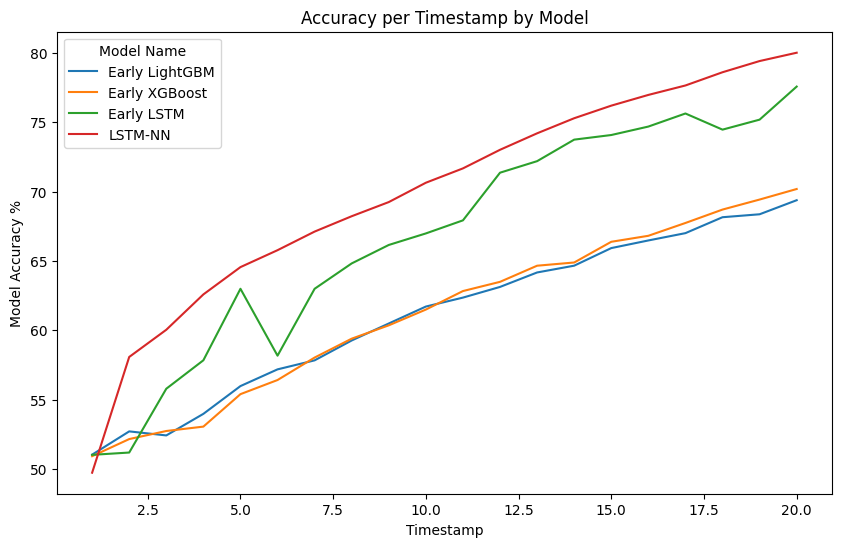

In [154]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=results, x='timestamp', y='accuracy', hue='model', ax=ax)
ax.set_title('Accuracy per Timestamp by Model')
ax.set_ylabel('Model Accuracy %')
ax.set_xlabel('Timestamp')
ax.legend(title='Model Name')